# Fractions Skill Score Verification - Single Hazard

In [74]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import xoak
import numpy as np
import matplotlib.pyplot as plt
import regionmask
import cartopy
import cartopy.crs as ccrs
import glob
%matplotlib inline
import pysteps
import ipywidgets as widgets

import warnings
warnings.filterwarnings('ignore')

### Defintions for Coarsening

In [2]:
def Data_Conv(ds):
    
    '''
    A defintion  
    
    Parameters
    ----------
    ds: xarray dataset
    
    Returns
    -------
    ds: returns a coarsened data with lat/long
    
    '''
    #load the geog file produce for WRF-BCC
    geog = xr.open_dataset("/home/scratch/WRF_BCC/geography/geo_em.d01.nc")
    geog = geog[['CLAT', 'CLONG']].coarsen(south_north=20, west_east=20, boundary='trim').mean()
    
    #coarsen the dataset to ~80-km
    ds = ds.coarsen(south_north=20, west_east=20, boundary='trim').sum()
    ds = xr.merge([ds, geog.squeeze()])
    ds = ds.rename({"CLONG": 'lon', 'CLAT': 'lat'})

    #assign lat/lon values of coarsen data and set index
    ds = ds.assign_coords({'x': ds.west_east, 'y': ds.south_north})
    ds = ds.assign_coords({'lon': ds.lon, 'lat': ds.lat})
    ds.xoak.set_index(['lat', 'lon'], 'sklearn_geo_balltree')
    
    return ds

In [64]:
#open dummy xarray dataset
ds = xr.open_dataset('/home/scratch/WRF_BCC/severe_weather/UP_HELI_MAX/historical/1990-1991/UP_HELI_MAX_historical-1990-1991_1990-10-01.nc')
ds = ds.sel(Time ='1990-10-01T00:00:00.000000000')
ds_copy = ds.copy()

## Create Widgets

In [4]:
#widget for selecting variable
var_widget = widgets.RadioButtons(
    options=[('Updraft Helicity', 'UH'), ('Updraft Vertical Velocity', 'UVV'), ('Downdraft Vertical Velocity', 'DVV')],
    layout={'width': 'max-content'},
    description='Variable:',
    disabled=False)

In [5]:
#widget for selecting hazard
haz_widget = widgets.RadioButtons(
    options=[('Tornado', 'tor'), ('Hail', 'hail'), ('Wind', 'wind')],
    layout={'width': 'max-content'},
    description='Hazard:',
    disabled=False)

In [6]:
#widget for selecting reflectivity range
refc_widget = widgets.IntRangeSlider(
    value=[40, 50],
    min=40,
    max=65,
    step=5,
    description='Reflectivity:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

In [7]:
#widget for selecting reflectivity range
UVV_widget = widgets.IntRangeSlider(
    value=[18, 24],
    min=15,
    max=35,
    step=1,
    description='Range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

In [62]:
#widget for selecting reflectivity range
UH_widget = widgets.IntRangeSlider(
    value=[35, 70],
    min=35,
    max=150,
    step=5,
    description='Range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

In [9]:
#widget for selecting reflectivity range
DVV_widget = widgets.IntRangeSlider(
    value=[18, 24],
    min=2,
    max=15,
    step=1,
    description='Range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

In [10]:
neigh_widget = widgets.IntSlider(
    value=200,
    min=0,
    max=3000,
    step=10,
    description='Pixel:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

In [60]:
thres_widget = widgets.IntSlider(
    value=20,
    min=0,
    max=200,
    step=1,
    description='Threshold:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

### Loading WRF-BCC Variable Data
The widget below allows you to select which WRF-BCC variable to currently test. NOTE: if you change the variable, you will need to rerun the cells below the widget again. You will have to run the cell above the widget before making a selection. Please select one before moving onto the next cell. After selection, you can run all cells up to the next widget.

In [12]:
#First Widget!
var_widget

RadioButtons(description='Variable:', layout=Layout(width='max-content'), options=(('Updraft Helicity', 'UH'),…

In [13]:
#load wrf-bcc dataset
#find all csv files for each variable and sort
files_refc = glob.glob('/home/scratch/jcorner1/syn_sev/dataframes/HIST_REFC*')
files_var = glob.glob(f'/home/scratch/jcorner1/syn_sev/dataframes/HIST_{var_widget.value}*')
files_refc.sort()
files_var.sort()

#concat all dataframes of same variable type together
df_refc = pd.concat(map(pd.read_csv, files_refc), ignore_index=True)
df_var = pd.concat(map(pd.read_csv, files_var), ignore_index=True)

#combine the new dataframes together
df = pd.concat([df_var, df_refc])

#get rid of the duplicates
df = df.drop_duplicates(subset=['x','y','Time'])
df

,Unnamed: 0,x,y,Time,UH,DBZ,UVV
0,0,753,483,1990-10-31T01:00:00.000000000,35.804810,13.807288,12.857470
1,1,754,483,1990-10-31T01:00:00.000000000,35.848896,37.720950,12.006787
2,2,749,411,1990-10-31T04:00:00.000000000,42.497177,51.801662,17.208110
3,3,750,411,1990-10-31T04:00:00.000000000,41.811430,40.762430,13.348378
4,4,750,412,1990-10-31T04:00:00.000000000,35.797220,40.055344,12.823191
...,...,...,...,...,...,...,...
50369937,3014602,909,700,2005-09-30T00:00:00.000000000,0.241252,40.251040,1.671814
50369938,3014603,908,701,2005-09-30T00:00:00.000000000,0.003803,40.213430,1.964281
50369939,3014604,919,701,2005-09-30T00:00:00.000000000,0.113389,40.785255,2.138664
50369940,3014605,920,702,2005-09-30T00:00:00.000000000,0.123360,40.707443,3.051859


In [ ]:
#load wrf-bcc dataset


In [14]:
#threshold logic for 

In [15]:
#threshold the files
df_wrf = df[((df['DBZ'] >= 40.0) & (df['UH'] >= 35.0))]
print(f'amount of rows removed from dataframe: {len(df) - len(df_wrf)}')
df_wrf

amount of rows removed from dataframe: 51316570


,Unnamed: 0,x,y,Time,UH,DBZ,UVV
2,2,749,411,1990-10-31T04:00:00.000000000,42.497177,51.801662,17.208110
3,3,750,411,1990-10-31T04:00:00.000000000,41.811430,40.762430,13.348378
4,4,750,412,1990-10-31T04:00:00.000000000,35.797220,40.055344,12.823191
10,10,655,107,1990-10-31T17:00:00.000000000,43.998700,48.578342,25.945530
11,11,656,107,1990-10-31T17:00:00.000000000,41.527390,55.626390,25.919870
...,...,...,...,...,...,...,...
3052279,222452,906,676,2005-09-30T00:00:00.000000000,43.327316,53.837643,8.723131
3052280,222453,907,676,2005-09-30T00:00:00.000000000,37.712870,43.664204,6.150899
3052281,222454,905,677,2005-09-30T00:00:00.000000000,37.796368,51.491848,6.550873
3052282,222455,906,677,2005-09-30T00:00:00.000000000,40.048130,52.623300,6.997382


In [16]:
#convert from raw count to convective days
df_wrf['Time'] = pd.to_datetime(df_wrf['Time']) + pd.DateOffset(hours=12)
df_wrf['New_Time'] = pd.to_datetime(df_wrf['Time']) + pd.DateOffset(hours=12)

#seperate timing values into their own column
df_wrf['Year'] = pd.to_datetime(df_wrf['New_Time']).dt.year
df_wrf['Month'] = pd.to_datetime(df_wrf['New_Time']).dt.month
df_wrf['Day'] = pd.to_datetime(df_wrf['New_Time']).dt.day

In [85]:
#drop duplicate dates
#df.drop_duplicates(subset=['x','y','Year', 'Month','Day'])

In [86]:
#df_wrf

,Unnamed: 0,x,y,Time,UH,DBZ,UVV,Year,Month,Day,Hour,New_Time
371,371,655,107,1990-10-31 17:00:00,43.998700,48.578342,25.945530,1990,10,31,17:00:00,1990-11-01 05:00:00
372,372,656,107,1990-10-31 17:00:00,41.527390,55.626390,25.919870,1990,10,31,17:00:00,1990-11-01 05:00:00
773,773,676,193,1990-11-12 09:00:00,36.960224,46.612453,18.155780,1990,11,12,09:00:00,1990-11-12 21:00:00
776,776,679,190,1990-11-12 10:00:00,40.487160,52.009808,21.638496,1990,11,12,10:00:00,1990-11-12 22:00:00
834,834,691,184,1990-11-16 12:00:00,36.634655,49.144615,20.081667,1990,11,16,12:00:00,1990-11-17 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
50369888,3014553,906,676,2005-09-30 00:00:00,43.327316,53.837643,8.723131,2005,9,30,00:00:00,2005-09-30 12:00:00
50369889,3014554,907,676,2005-09-30 00:00:00,37.712870,43.664204,6.150899,2005,9,30,00:00:00,2005-09-30 12:00:00
50369890,3014555,905,677,2005-09-30 00:00:00,37.796368,51.491848,6.550873,2005,9,30,00:00:00,2005-09-30 12:00:00
50369891,3014556,906,677,2005-09-30 00:00:00,40.048130,52.623300,6.997382,2005,9,30,00:00:00,2005-09-30 12:00:00


In [44]:
#create an array of zeros
zeros = np.zeros((899,1399))

#iterate through each row of the dataframe to and add one for each instance 
for rid, row in df_wrf.iterrows():
    zeros[row['y'], row['x']] = zeros[row['y'], row['x']] + 1
    
#nan all the zero values    
zeros[zeros == 0.0] = np.nan

#assign the array to the netcdf file
ds = ds_copy.assign(UP_HELI_MAX = (('south_north', 'west_east'), zeros))

#coarsen the file 
ds_cor = Data_Conv(ds)

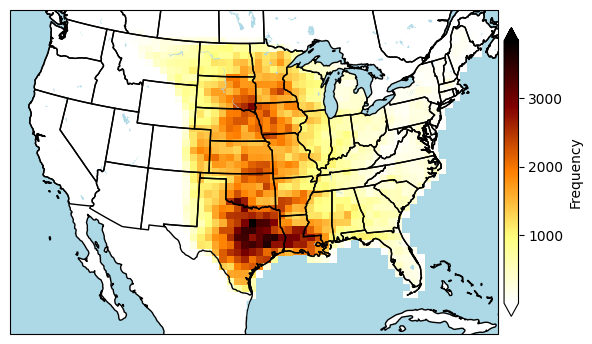

In [18]:
#Create a subplot
plt.figure(figsize=(7.5,7.5))
ax = plt.subplot(1,1,1, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))

#create nans for the 0 data spots
data = ds_cor.UP_HELI_MAX.values
data[data==0] = np.nan
c = ax.pcolormesh(ds_cor.lon.values, ds_cor.lat.values, data, cmap='afmhot_r', transform=cartopy.crs.PlateCarree(), vmax=int(np.nanmax(data)))

#add features to help reference map
ax.add_feature(cartopy.feature.STATES, zorder=2)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.LAND, facecolor='white')
ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue')
ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue')
ax.set_extent([-120, -74, 20, 50])

#create colorbar
cbar = plt.colorbar(c, shrink=0.5, pad=0.01, extend='both', ticks=list(range(0, int(np.nanmax(data)), 1000)), ax=ax)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='Frequency', size=10)

## Loading SPC Local Storm Report Data
The widget below allows you to select which hazard from the SPC LSR data archive file to currently test. NOTE: if you change the hazard, you will need to rerun the cells below the widget again. You will have to run the cell above the widget before making a selection. Please select one before moving onto the next cell. After selection, you can run all cells up to the next widget.

In [19]:
#Second Widget!
haz_widget

RadioButtons(description='Hazard:', layout=Layout(width='max-content'), options=(('Tornado', 'tor'), ('Hail', …

In [56]:
#load the SPC reports
#NOTE: These data have been regridded to the 80-km previously
df_obs = pd.read_csv(f'/home/scratch/jcorner1/syn_sev/dataframes/SPC_LSRs_regridded_{haz_widget.value}_fix.csv')

In [57]:
#add the lat and lon columns based on values in the nearest column
lat = []
lon = []

#iterate through each row to find the lat/lon
for rid, row in df_obs.iterrows():
    lat.append(row.Nearest.split()[1])
    lon.append(row.Nearest.split()[7])

#append the values to the dataframe
df_obs['Lat'] = lat
df_obs['Lon'] = lon

#combine date and time to a datetime object
df_obs['datetime'] = pd.to_datetime(df_obs['date'] + ' ' + df_obs['time']) + pd.DateOffset(hours=6)
df_obs['con_date'] = (df_obs['datetime'] + pd.DateOffset(hours=12)).dt.date

#drop duplicates to convert to convective days
df_obs = df_obs.drop_duplicates(subset=['Lat','Lon','con_date'])
df_obs

,Unnamed: 0.1,Unnamed: 0,om,yr,mo,dy,date,time,tz,st,...,f1,f2,f3,f4,mt,Nearest,Lat,Lon,datetime,con_date
0,0,71631,5767,1990,10,11,1990-10-11,18:30:00,3,GA,...,49,0,0,0,NaN,"(882 30.700493\nName: lat, dtype: float32, ...",30.700493,-82.248817,1990-10-12 00:30:00,1990-10-12
1,1,71632,5768,1990,10,11,1990-10-11,19:00:00,3,GA,...,25,0,0,0,NaN,"(951 31.360302\nName: lat, dtype: float32, ...",31.360302,-82.119484,1990-10-12 01:00:00,1990-10-12
2,2,71633,5769,1990,10,11,1990-10-11,21:00:00,3,GA,...,303,0,0,0,NaN,"(1088 32.792816\nName: lat, dtype: float32,...",32.792816,-82.641296,1990-10-12 03:00:00,1990-10-12
3,3,71634,5770,1990,10,12,1990-10-12,03:30:00,3,GA,...,59,0,0,0,NaN,"(1225 34.2262\nName: lat, dtype: float32, 1...",34.2262,-83.182823,1990-10-12 09:30:00,1990-10-12
5,5,71636,5772,1990,10,14,1990-10-14,18:15:00,3,WI,...,25,0,0,0,NaN,"(2044 42.98877\nName: lat, dtype: float32, ...",42.98877,-89.653122,1990-10-15 00:15:00,1990-10-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149332,149332,227488,10507,2005,9,9,2005-09-09,13:00:00,3,MN,...,7,0,0,0,NaN,"(2452 47.228268\nName: lat, dtype: float32,...",47.228268,-95.021698,2005-09-09 19:00:00,2005-09-10
149333,149333,227489,10508,2005,9,9,2005-09-09,13:15:00,3,MN,...,119,0,0,0,NaN,"(2520 47.90831\nName: lat, dtype: float32, ...",47.90831,-95.986839,2005-09-09 19:15:00,2005-09-10
149334,149334,227490,10509,2005,9,9,2005-09-09,14:52:00,3,UT,...,37,0,0,0,NaN,"(1469 37.189175\nName: lat, dtype: float32,...",37.189175,-109.790741,2005-09-09 20:52:00,2005-09-10
149335,149335,227491,10510,2005,9,9,2005-09-09,17:10:00,3,AZ,...,13,0,0,0,NaN,"(1121 33.566952\nName: lat, dtype: float32,...",33.566952,-111.652351,2005-09-09 23:10:00,2005-09-10


In [58]:
#create an array of zeros
zeros = np.zeros((ds_cor.UP_HELI_MAX.values.shape))

#iterate through each row of the dataframe to and add one for each instance
for rid, row in df_obs.iterrows():
    y1, x1 = np.where(ds_cor.lat.values == float(row.Lat))
    y2, x2 = np.where(ds_cor.lon.values == float(row.Lon))
    zeros[y1[0], x2[0]] = zeros[y1[0], x2[0]] + 1
    
ds_obs = ds_copy.assign(UP_HELI_MAX = (('south_north', 'west_east'), zeros))

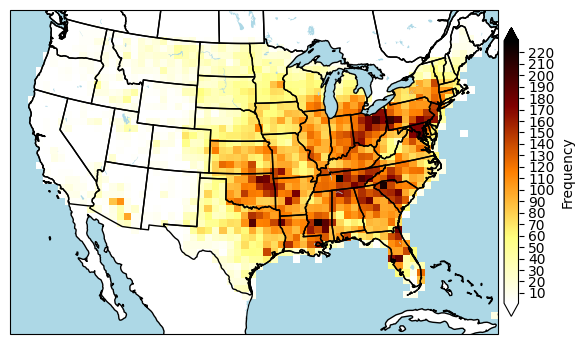

In [59]:
#Create a subplot
plt.figure(figsize=(7.5,7.5))
ax = plt.subplot(1,1,1, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))

#create nans for the 0 data spots
data = ds_obs.UP_HELI_MAX.values
data[data==0] = np.nan
c = ax.pcolormesh(ds_cor.lon.values, ds_cor.lat.values, data, cmap='afmhot_r', transform=cartopy.crs.PlateCarree(), vmax=int(np.nanmax(data)))

#add features to help reference map
ax.add_feature(cartopy.feature.STATES, zorder=2)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.LAND, facecolor='white')
ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue')
ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue')
ax.set_extent([-120, -74, 20, 50])

#create colorbar
cbar = plt.colorbar(c, shrink=0.5, pad=0.01, extend='both', ticks=list(range(0, int(np.nanmax(data)), 10)), ax=ax)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='Frequency', size=10)

## Verfication Testing
There are a few widgets below, so pay attention to what each on of them does:

* **First Widget:** Controls the reflectivity range values to test on with a step interval of 5 (e.g., a range of 40-50 will test 40, 45, and 50 dBZ).
* **Second Widget:** Controls the range of values of the tested variable. These update based on the variable inputted, therefore make sure to rerun it properly. 
* **Third Widget:** Controls the neighborhood size used during the verification (e.g., 100 pixels is a 10x10 neighborhood).
* **Fourth Widget:** Controls the threshold for binarzation [e.g., 12 convective days threshold means all values above (below) become a 1 (0)]


NOTE: if you changed anything above (especially the variable), you will need to rerun the cells below that widget again. Run the cell above the widget prior to making a selection. Please adjust the widget to the desired range or value. Slowly repeat these steps for each of the widgets. 

In [51]:
# Reflectivity Widget (First)
refc_widget

IntRangeSlider(value=(40, 50), continuous_update=False, description='Reflectivity:', max=65, min=40, step=5)

In [63]:
# Varaible Widget (Second)
locals()[f'{var_widget.value}_widget']

IntRangeSlider(value=(35, 70), continuous_update=False, description='Range:', max=150, min=35, step=5)

In [54]:
# Neighborhood Widget (Third)
neigh_widget

IntSlider(value=200, continuous_update=False, description='Pixel:', max=3000, step=10)

In [61]:
# Threshold Widget (Fourth)
thres_widget

IntSlider(value=20, continuous_update=False, description='Threshold:', max=200)

### Verification with FSS

In [ ]:
#Set the step value based on the variable used.
if Var_widget.value == 'UH':
    step = 5

else:
    step = 1

In [21]:
#create a new dataframe
df = pd.DataFrame(columns=['DBZ', 'UH', 'FSS'])

#iterate through UH and Z values for subsetting
for refc in np.arange(refc_widget.value[0],refc_widget.value[1]+1,5):
    for uh in np.arange(locals()[f'{Var_widget.value}_widget'].value[0], locals()[f'{Var_widget.value}_widget'].value[1]+1, step):
        
        #subset the dataframe based on current threshold values
        df_sub = df_wrf[((df_wrf['DBZ'] >= refc) & (df_wrf['UH'] >= uh))]
        
        #create an array of zeros
        zeros = np.zeros((899,1399))

        #iterate through each row of the dataframe to and add one for each instance 
        for rid, row in df_sub.iterrows():
            zeros[row['y'], row['x']] = zeros[row['y'], row['x']] + 1

        #nan all the zero values    
        zeros[zeros == 0.0] = np.nan

        #assign the array to the netcdf file
        ds = ds_copy.assign(UP_HELI_MAX = (('south_north', 'west_east'), zeros))

        #coarsen the file 
        ds_cor = Data_Conv(ds)
        
        #verify with FSS!
        fss = pysteps.verification.spatialscores.fss(ds_cor.UP_HELI_MAX.values, ds_obs.UP_HELI_MAX.values, 50, 100)
        
        print(f'UH:{uh}   DBZ:{refc}   DIFF:{len(df_obs) - len(df_sub)}   FSS:{fss}')
        df = df.append({'DBZ': refc, 'UH': uh, 'DIFF':len(df_obs) - len(df_sub), 'FSS':fss}, ignore_index=True)

UH:60   DBZ:40   DIFF:-281778   FSS:0.07889414414589935
UH:65   DBZ:40   DIFF:-223292   FSS:0.08402261075393769
UH:70   DBZ:40   DIFF:-177987   FSS:0.08745518961322785
UH:75   DBZ:40   DIFF:-142354   FSS:0.09218022844424367
UH:80   DBZ:40   DIFF:-113906   FSS:0.09832341431299962
UH:85   DBZ:40   DIFF:-91076   FSS:0.10526993338794244
UH:90   DBZ:40   DIFF:-72741   FSS:0.11157537502271808
UH:95   DBZ:40   DIFF:-57653   FSS:0.12075161303657245
UH:100   DBZ:40   DIFF:-45276   FSS:0.13158798980908015
UH:105   DBZ:40   DIFF:-34870   FSS:0.15078713162864632
UH:110   DBZ:40   DIFF:-26475   FSS:0.17494633603728227
UH:115   DBZ:40   DIFF:-19267   FSS:0.21252157104512903
UH:120   DBZ:40   DIFF:-13369   FSS:0.26025438864582295
UH:60   DBZ:45   DIFF:-204421   FSS:0.08466992350844482
UH:65   DBZ:45   DIFF:-161960   FSS:0.08898242492940978
UH:70   DBZ:45   DIFF:-128859   FSS:0.0935431980050071
UH:75   DBZ:45   DIFF:-102653   FSS:0.09999539414527958
UH:80   DBZ:45   DIFF:-81760   FSS:0.107756611939111

### Plot Verification Results

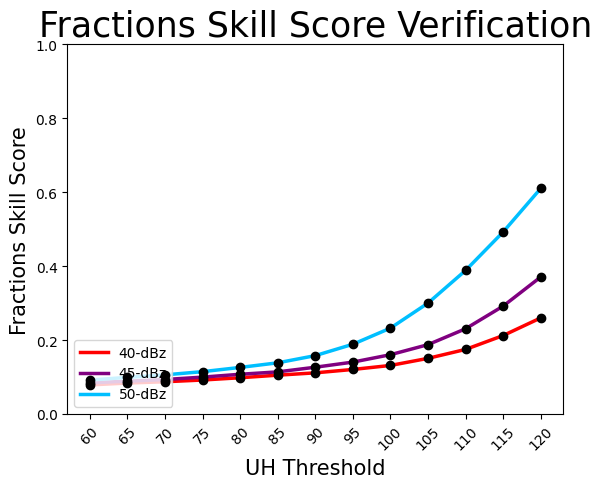

In [34]:
test = 

#plot the scores of the FSS
plt.plot(np.arange(1,len(np.arange(60,121,5))+1,1), df.FSS.values[:13], color = 'red', lw=2.5)
plt.plot(np.arange(1,len(np.arange(60,121,5))+1,1), df.FSS.values[13:26], color = 'purple', lw=2.5)
plt.plot(np.arange(1,len(np.arange(60,121,5))+1,1), df.FSS.values[26:], color = 'deepskyblue', lw=2.5)

plt.scatter(np.arange(1,len(np.arange(60,121,5))+1,1), df.FSS.values[:13], color = 'black', zorder=10)
plt.scatter(np.arange(1,len(np.arange(60,121,5))+1,1), df.FSS.values[13:26], color = 'black', zorder=10)
plt.scatter(np.arange(1,len(np.arange(60,121,5))+1,1), df.FSS.values[26:], color = 'black', zorder=10)

plt.title('FSS Verification',fontsize=25)

plt.yticks(ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.xticks(ticks = np.arange(1,len(np.arange(60,121,5))+1,1), labels = np.arange(60,121,5), rotation=45)

plt.xlabel(f'{} Threshold', size = 15)
plt.ylabel('Fractions Skill Score', size = 15)

plt.legend(['40-dBz', '45-dBz', '50-dBz'], loc ='lower left')

In [24]:
len(np.arange(35,121,5))

18

In [29]:
np.arange(35,121,5)

array([ 35,  40,  45,  50,  55,  60,  65,  70,  75,  80,  85,  90,  95,
       100, 105, 110, 115, 120])